In [1]:
from scipy.io import wavfile
from matplotlib import pyplot as plt
import numpy as np
import librosa
import scipy as sp

In [2]:
data_path = "../data/archive/musicnet/musicnet/train_data/"

In [3]:
rate, wav = wavfile.read(data_path + "1727.wav")

In [4]:
rate

44100

In [5]:
wav

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

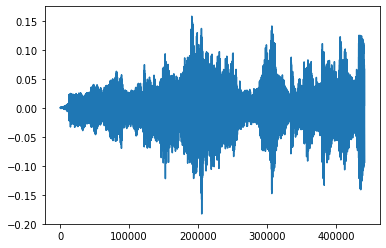

In [6]:
plt.plot(wav[0:rate*10])

In [7]:
n_fft = 2048
hop_length = 1024
mel = librosa.feature.melspectrogram(y=wav, sr=rate, n_fft=n_fft, hop_length=hop_length, fmax=8000)

In [8]:
mel_db = librosa.power_to_db(mel, ref=np.max)
mel_db.shape

(128, 19254)

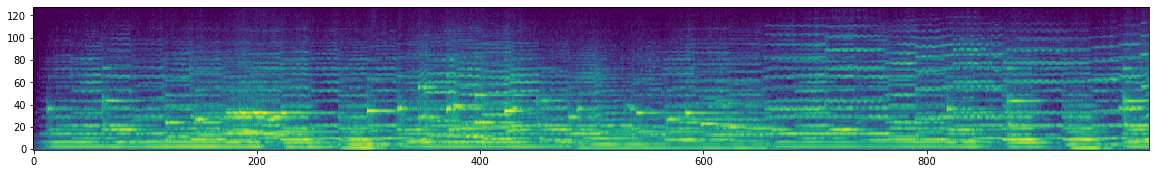

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(mel_db[:,:1000])
ax.invert_yaxis()

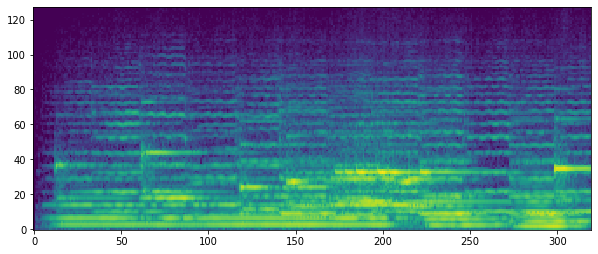

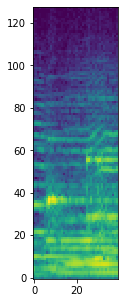

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
plt.imshow(mel_db[:,0:320])
ax.invert_yaxis()
fig, ax = plt.subplots(figsize=(10,5))
plt.imshow(mel_db[:,320:360])
ax.invert_yaxis()

In [11]:
def normalize_mel(mel):
    return (mel + 80)/80
def unnormalize_mel(nmel):
    return nmel*80 - 80

In [12]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable, Function
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader

from time import time
import copy, math

In [13]:
block_size = 320
pred_step = 40

In [14]:
class music_data():
    def __init__(self, data, block_size, pred_step):
        self.numpy = data.T
        self.block_size = block_size
        self.pred_step = pred_step
        self.shape = data.shape
        self.data = []
        
    def init_data(self):
        for i in range(self.shape[1] - self.block_size - self.pred_step):
            self.data.append((self.numpy[i:i+self.block_size], self.numpy[i+pred_step:i+self.block_size+pred_step]))
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def __len__(self):
        return len(self.data)

In [15]:
dataset = music_data(normalize_mel(mel_db), block_size, pred_step)
dataset.init_data()
batch_size=32

In [16]:
dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

In [17]:
for i, batch in enumerate(dataloader):
    print(batch[0][0])
    print(batch[1][0])
    break

tensor([[0.5305, 0.6744, 0.7211,  ..., 0.0157, 0.0134, 0.0485],
        [0.5223, 0.6653, 0.7115,  ..., 0.0105, 0.0128, 0.0204],
        [0.5084, 0.6516, 0.6981,  ..., 0.0621, 0.0576, 0.0359],
        ...,
        [0.3297, 0.3719, 0.4230,  ..., 0.0000, 0.0000, 0.0333],
        [0.3580, 0.4509, 0.4777,  ..., 0.0225, 0.0000, 0.0312],
        [0.3957, 0.4532, 0.4271,  ..., 0.0563, 0.0391, 0.0285]])
tensor([[0.4666, 0.5537, 0.7461,  ..., 0.0381, 0.0128, 0.0414],
        [0.4762, 0.5919, 0.7707,  ..., 0.0499, 0.0547, 0.0128],
        [0.4896, 0.5916, 0.7800,  ..., 0.0315, 0.0268, 0.0572],
        ...,
        [0.4151, 0.5048, 0.4644,  ..., 0.0000, 0.0000, 0.0183],
        [0.4060, 0.5307, 0.5566,  ..., 0.0137, 0.0000, 0.0000],
        [0.3826, 0.4970, 0.5458,  ..., 0.0000, 0.0058, 0.0291]])


In [18]:
dec_layer1 = nn.TransformerDecoderLayer(128, 4, dim_feedforward=256, batch_first=True)
dec_layer2 = nn.TransformerDecoderLayer(128, 4, dim_feedforward=256, batch_first=True)
conv1 = nn.Conv1d(128, 128, 25, padding='same')
conv2 = nn.Conv1d(128, 128, 25, padding='same')

In [19]:
for i, batch in enumerate(dataloader):
    print(batch[0].shape)
    y1 = conv1(batch[0].transpose(1, 2)).transpose(1, 2)
    y2 = conv2(batch[0].transpose(1, 2)).transpose(1, 2)
    print(y1.shape, y2.shape)
    break

torch.Size([32, 320, 128])
torch.Size([32, 320, 128]) torch.Size([32, 320, 128])


In [20]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [121]:
class MusicModel(nn.Module):
    def __init__(self, d_model, kernel_size, d_ff, h, N, device):
        super(MusicModel, self).__init__()
        self.d_model = d_model
        self.N = N
        self.F1 = nn.Sequential(\
            nn.Conv1d(d_model, d_model//2, 2, stride=2),
            nn.ReLU(),
            nn.Conv1d(d_model//2, d_model//2, kernel_size, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(d_model//2), 
            nn.Upsample(scale_factor=2, mode="linear"), 
            nn.Conv1d(d_model//2, d_model, kernel_size, padding='same'), 
            nn.ReLU(),
            nn.Conv1d(d_model, d_model, kernel_size, padding='same'),                    
        )
        self.F2 = copy.deepcopy(self.F1)
        
        self.pe = PositionalEncoding(d_model, 0.1)
        self.transformer1 = nn.ModuleList([nn.TransformerEncoderLayer(\
            d_model, 
            h,
            dim_feedforward=d_ff,
            batch_first=True
            ) for i in range(N)])
        self.transformer2 = nn.ModuleList([nn.TransformerEncoderLayer(\
            d_model, 
            h,
            dim_feedforward=d_ff,
            batch_first=True
            ) for i in range(N)])
        
        self.device = device
        self.to(device)
        
    def forward(self, x):
        z1 = self.F1(x.transpose(1, 2)).transpose(1, 2).pow(2)
        z2 = self.F2(x.transpose(1, 2)).transpose(1, 2).pow(2)
        
        y1 = self.pe(z1)
        y2 = self.pe(z2)
        mask = self.get_mask(x.size(1)).to(self.device)
        
        for i in range(self.N):
            y1 = self.transformer1[i](y1, src_mask=mask)
            y2 = self.transformer2[i](y2, src_mask=mask)
            
        y1 = y1.pow(2)
        y2 = y2.pow(2)
        return y1, y2, z1, z2
    
    def get_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        return mask

In [122]:
model = MusicModel(128, 25, 256, 4, 3, torch.device("cpu"))

In [123]:
for batch in dataloader:
    out = model(batch[0])
    break

In [124]:
out[0].shape, out[1].shape

(torch.Size([32, 320, 128]), torch.Size([32, 320, 128]))

In [125]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
    def zero_grad(self):
        self.optimizer.zero_grad()
        
def get_std_opt(model, warmup):
    return NoamOpt(model.d_model, 2, warmup,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [126]:
len(dataset) / batch_size

590.4375

In [127]:
d_model = 128
kernel_size = 25
d_ff = 256
h = 4
N = 3
device = torch.device('cuda')

In [134]:
model = MusicModel(d_model, kernel_size, d_ff, h, N, device)
model.to(device)
crit = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [135]:
model.train()
for e in range(20):
    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y1, y2, z1, z2 = model(x)
        loss1 = crit(y1 + y2, y.to(device))
        #loss2 = crit(z1 + z2, torch.clone(x))
        loss = loss1
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        if i % 100 == 0:
            print(loss.item())
    print(e)

6.589293003082275
2.733199119567871
2.4451942443847656
2.2628414630889893
2.014545202255249
1.833587646484375
0
1.6689239740371704


KeyboardInterrupt: 

In [136]:
model.eval()
model.to(device)
for (x, y) in dataloader:
    x = x.to(device)
    y1, y2, z1, z2 = model(x)
    break

In [137]:
y1.shape, y2.shape

(torch.Size([32, 320, 128]), torch.Size([32, 320, 128]))

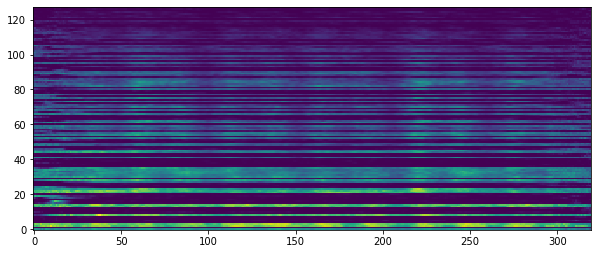

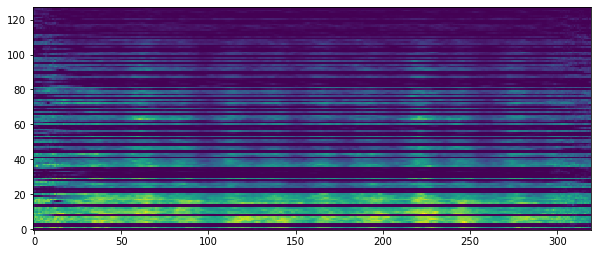

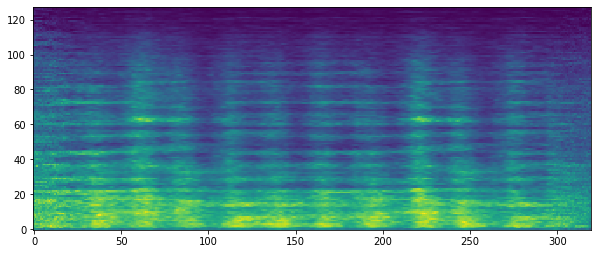

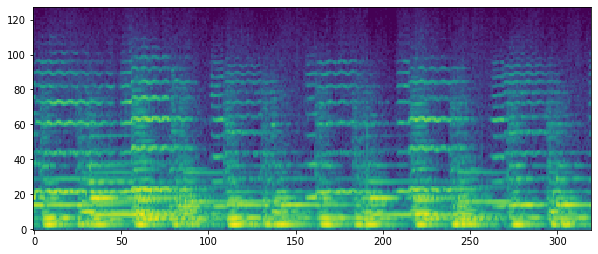

In [132]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(z1[0].detach().cpu().numpy().T)
ax.invert_yaxis()
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(z2[0].detach().cpu().numpy().T)
ax.invert_yaxis()
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow((z1[0]+z2[0]).detach().cpu().numpy().T)
ax.invert_yaxis()
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(x[0].detach().cpu().numpy().T)
ax.invert_yaxis()

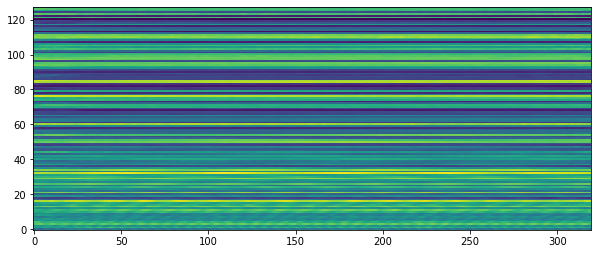

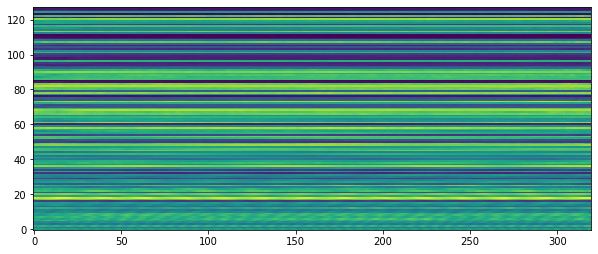

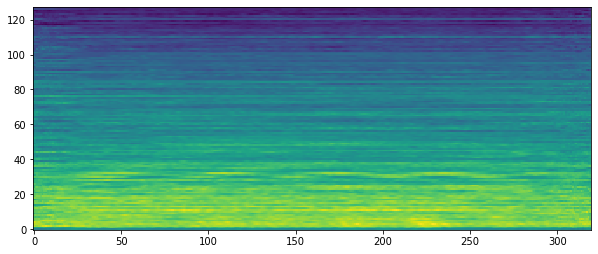

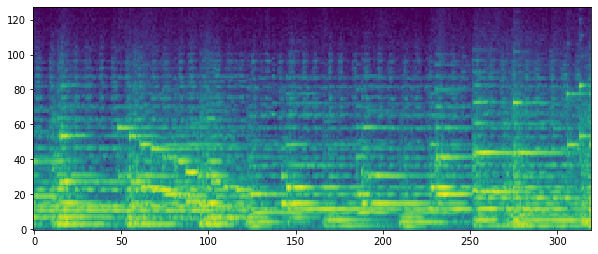

In [138]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(y1[0].detach().cpu().numpy().T)
ax.invert_yaxis()
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(y2[0].detach().cpu().numpy().T)
ax.invert_yaxis()
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow((y1+y2)[0].detach().cpu().numpy().T)
ax.invert_yaxis()
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(y[0].cpu().numpy().T)
ax.invert_yaxis()

In [85]:
y1[0]

tensor([[ 0.0399, -0.0072,  0.2288,  ..., -0.3357, -0.1081,  0.0219],
        [ 0.0470, -0.0043,  0.2319,  ..., -0.3336, -0.1073,  0.0240],
        [ 0.0497, -0.0051,  0.2329,  ..., -0.3320, -0.1059,  0.0259],
        ...,
        [-0.0193, -0.0881,  0.2004,  ..., -0.3466, -0.1224, -0.0195],
        [-0.0252, -0.0894,  0.1997,  ..., -0.3470, -0.1229, -0.0206],
        [-0.0271, -0.0868,  0.2028,  ..., -0.3466, -0.1234, -0.0214]],
       device='cuda:0', grad_fn=<SelectBackward0>)